# Titanic dataset

## Workflow steps.

1. Problem definition.
2. Data.
3. Evaluation of model.
4. Features breakdown.
5. Modelling.

## 1. Problem definition.

> Based on titanic dataset, one should make predictions about what people are keen to surival during the shipwreck and which are not (**classification problem**).

## 2. Data. 

Dataset is taken from Kaggle: https://www.kaggle.com/c/titanic

## 3. Evaluation of model.

Model is considered successful if gets perfect score of 1.0.

## 4. Features breakdown.

Preparation of all needed tools:

In [1]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Other Python libraries
import re
from collections import defaultdict

# Scikit-learn tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, accuracy_score

# Scikit-learn regression models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# Scikit-learn classification models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Scikit-learn multiclass
from sklearn.multiclass import OneVsRestClassifier

%config InlineBackend.figure_format = 'retina'

In [2]:
main_data = pd.read_csv("train.csv", index_col="PassengerId")
main_data

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
...               ...     ...   
887                 0       2   
888                 1       1   
889                 0       3   
890                 1       1   
891                 0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
...                                                        ...     ...   ...   
887                                      Montvila, Rev. Juozas    male  27.0   
888                               Graham, Miss. Margaret Edith  female  19.0   
889                   Johnston, Miss. Catherine Helen "Carrie"  female   NaN   
890                                      Behr, Mr. Karl Howell    male  26.0   
891                                        Dooley, Mr. Patrick    male  32.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S  
...            ...    ...               ...      ...   ...      ...  
887              0      0            211536  13.0000   NaN        S  
888              0      0            112053  30.0000   B42        S  
889              1      2        W./C. 6607  23.4500   NaN        S  
890              0      0            111369  30.0000  C148        C  
891              0      0            370376   7.7500   NaN        Q  

[891 rows x 11 columns]

In [3]:
test_data = pd.read_csv("test.csv", index_col="PassengerId")

In [4]:
# Making communicative reference table.
variables = main_data.columns
definitions = ["Survival", "ticket class", "name", "sex", "age in years",
               "# of siblings/spouses aboard the Titanic",
               "# of parents/children aboard the Titanic", "ticket number", "passenger fare", "cabin number",
               "port of embarkation"]
keys = ["0 = No, 1 = Yes", "1st, 2nd, 3rd", "","", "", "", "", "", "", "", "Cherbourg, Queenstown, Southampton"]
len(variables), len(definitions), len(keys)

(11, 11, 11)

In [5]:
ref_table = pd.DataFrame([definitions, keys], columns=variables, index=["Definitions", "Keys"]).T
ref_table

Definitions  \
Survived                                  Survival   
Pclass                                ticket class   
Name                                          name   
Sex                                            sex   
Age                                   age in years   
SibSp     # of siblings/spouses aboard the Titanic   
Parch     # of parents/children aboard the Titanic   
Ticket                               ticket number   
Fare                                passenger fare   
Cabin                                 cabin number   
Embarked                       port of embarkation   

                                        Keys  
Survived                     0 = No, 1 = Yes  
Pclass                         1st, 2nd, 3rd  
Name                                          
Sex                                           
Age                                           
SibSp                                         
Parch                                         
Ticket                                        
Fare                                          
Cabin                                         
Embarked  Cherbourg, Queenstown, Southampton

# Analysis

In [6]:
main_data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
test_data.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

The first vivid problem is NaN values in two feature columns - `Cabin` and `Age`. There are missing values in both datasets and fulfilling them is a must.

In [8]:
# Number of people died vs. number of people survived - the dataset is not fully balanced:
main_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Plan for Modelling 1:

1. Analyze `Name` feature:
* assign classes based on prepositions - `Prep_classes`.

2. Analyze `Cabin` feature:
* replace `Cabin` with `Letters` (left `Cabin_numbers` off for the next modelling since there is no clear way to extrapolate this feature to `NaN` values).

3. Fill `NaN` values in `Cabin`:
* assign N letter for missing values, G, and T letters (predicting the `Cabin` values and using them in final model is much better, but we will do it after baseline modelling).

4. Analyze `Age` feature.
* predict NaN values using kNN, RandomForestRegressor, LinearRegressor and SVR
* drop `Cabin`, `Fare` for predictions

5. Fill `NaN` values in `Age`.
* Master = 5

6. Analyze `Ticket` feature.
7. Analyze `Sex` feature.
8. Check distributions for all other numerical columns.
9. Make baseline models and check results.

### Prepositions

In [9]:
# Using feature encoding and regex to get prepositions of names:

def get_preps(names):
    prepositions = list()
    for person in names:
        preposition = re.findall("[A-Z][a-z]+\.", person)
        if preposition not in prepositions:
            prepositions.append(preposition)

    prepositions = np.array(prepositions).reshape(len(prepositions))
    return prepositions

prepositions = get_preps(main_data["Name"])

print(f"We have {len(prepositions)} prepositions: ")
print(prepositions)

We have 17 prepositions: 
['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'Countess.' 'Jonkheer.']


In [10]:
# change the prepositions in dataset

def names_to_preps(names):
    prep = []
    for person in names:
        preposition = re.findall("[A-Z][a-z]+\.", person)
        prep += preposition

    prep = np.array(prep).ravel()
    
    return prep

prep = names_to_preps(main_data["Name"])
prep = pd.DataFrame(data=prep, columns=["Prepositions"], index=main_data.index)
main_data = pd.concat([main_data, prep], axis=1)
main_data.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  \
PassengerId                                                           
1                1      0         A/5 21171   7.2500   NaN        S   
2                1      0          PC 17599  71.2833   C85        C   
3                0      0  STON/O2. 3101282   7.9250   NaN        S   
4                1      0            113803  53.1000  C123        S   
5                0      0            373450   8.0500   NaN        S   

            Prepositions  
PassengerId               
1                    Mr.  
2                   Mrs.  
3                  Miss.  
4                   Mrs.  
5                    Mr.

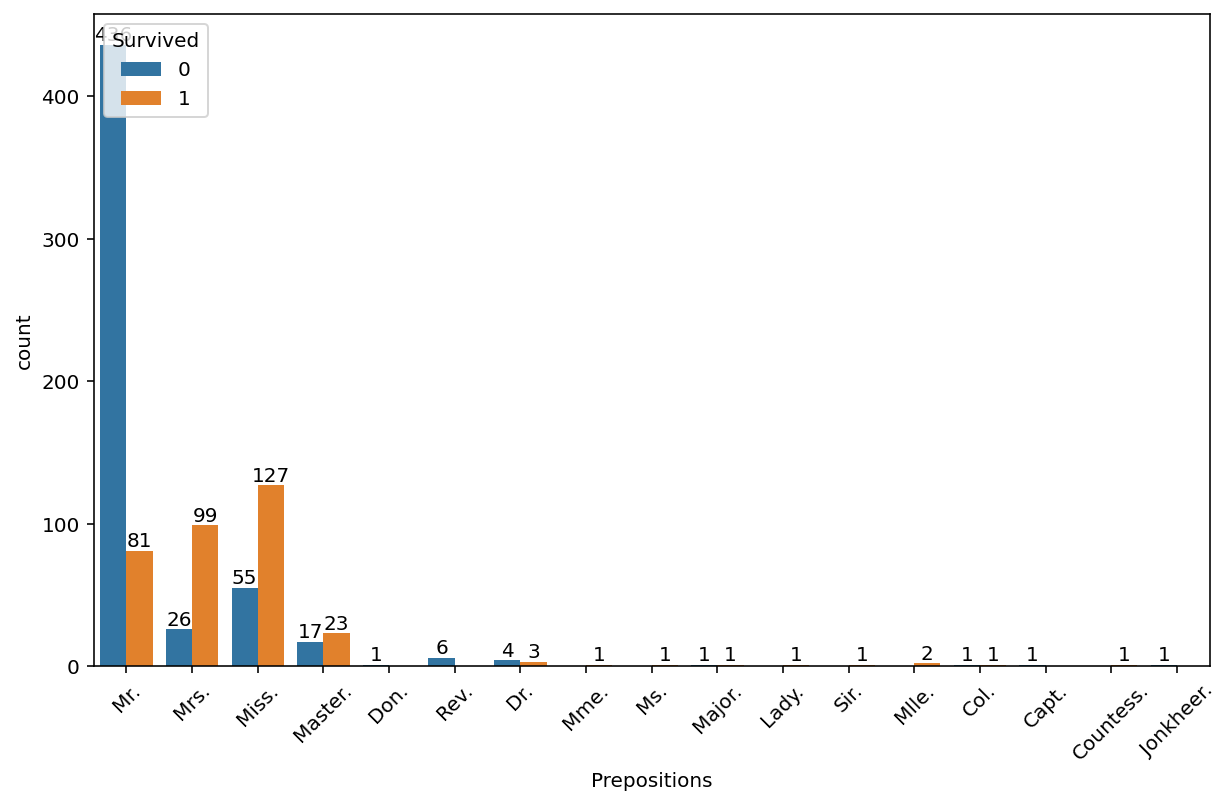

In [11]:
plt.rcParams["figure.figsize"] = (10,4)

fig, ax = plt.subplots(figsize=(10,6))

graph = sns.countplot(ax=ax, x="Prepositions", hue="Survived", data=main_data)
graph.set_xticklabels(graph.get_xticklabels(), rotation=45)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

We can make the following distinction:

1. Mr., Mrs., Miss., and Master. can all be different classes since they represent different distributions - 1,2,3,4.

2. Dr., Major., and Col. can be assigned the same class since they are outliers with 50/50 probability of survival - 5.

3. Sir., Mme., Ms., Lady., Countess., and Mlle. can be assigned the same class since they represent (outliers) honored women (Sir is only men) who all survived - 6.

4. Rev., Don., Capt,. and Jonkheer can be assigned the same class based that they all died - 7.

5. Any other preposition could be assigned 5 because otherwise, the new class will be an outlier.

In [12]:
def assign_prep_classes(prepositions: pd.Series):
    preps = []
    for prep in prepositions:
        if prep in ["Mr."]:
            preps.append(1)
        elif prep in ["Mrs."]:
            preps.append(2)
        elif prep in ["Miss."]:
            preps.append(3)
        elif prep in ["Master."]:
            preps.append(4)
        elif prep in ["Dr.", "Major.", "Col."]:
            preps.append(5)
        elif prep in ["Sir.", "Mme.", "Ms.", "Lady.", "Countess", "Mlle."]:
            preps.append(6)
        elif prep in ["Rev.", "Don.", "Capt.", "Jonkheer"]:
            preps.append(7)
        else:
            preps.append(5)

    a = pd.Series(data=preps, index=prepositions.index)
    return a

In [13]:
main_data["Prep_classes"] = assign_prep_classes(main_data["Prepositions"])
main_data.drop("Prepositions", axis=1, inplace=True)

In [14]:
main_data.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  \
PassengerId                                                           
1                1      0         A/5 21171   7.2500   NaN        S   
2                1      0          PC 17599  71.2833   C85        C   
3                0      0  STON/O2. 3101282   7.9250   NaN        S   
4                1      0            113803  53.1000  C123        S   
5                0      0            373450   8.0500   NaN        S   

             Prep_classes  
PassengerId                
1                       1  
2                       2  
3                       3  
4                       2  
5                       1

In [15]:
# create one function to use in modelling to combine all the steps above
def names_to_classes(df):
    """
    Adds new column "Prep_classes" to df.
    """
    df_preps = names_to_preps(df["Name"])
    df_preps = pd.Series(data=df_preps, index=df.index, name="Prepositions")
    df["Prep_classes"] = assign_prep_classes(df_preps)
    return df

### Cabin correlation

In [16]:
# How many cabins we have and what format are they?
cabins = main_data.dropna(subset=["Cabin"])
cabins

Survived  Pclass  \
PassengerId                     
2                   1       1   
4                   1       1   
7                   0       1   
11                  1       3   
12                  1       1   
...               ...     ...   
872                 1       1   
873                 0       1   
880                 1       1   
888                 1       1   
890                 1       1   

                                                          Name     Sex   Age  \
PassengerId                                                                    
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
7                                      McCarthy, Mr. Timothy J    male  54.0   
11                             Sandstrom, Miss. Marguerite Rut  female   4.0   
12                                    Bonnell, Miss. Elizabeth  female  58.0   
...                                                        ...     ...   ...   
872           Beckwith, Mrs. Richard Leonard (Sallie Monypeny)  female  47.0   
873                                   Carlsson, Mr. Frans Olof    male  33.0   
880              Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)  female  56.0   
888                               Graham, Miss. Margaret Edith  female  19.0   
890                                      Behr, Mr. Karl Howell    male  26.0   

             SibSp  Parch    Ticket     Fare        Cabin Embarked  \
PassengerId                                                          
2                1      0  PC 17599  71.2833          C85        C   
4                1      0    113803  53.1000         C123        S   
7                0      0     17463  51.8625          E46        S   
11               1      1   PP 9549  16.7000           G6        S   
12               0      0    113783  26.5500         C103        S   
...            ...    ...       ...      ...          ...      ...   
872              1      1     11751  52.5542          D35        S   
873              0      0       695   5.0000  B51 B53 B55        S   
880              0      1     11767  83.1583          C50        C   
888              0      0    112053  30.0000          B42        S   
890              0      0    111369  30.0000         C148        C   

             Prep_classes  
PassengerId                
2                       2  
4                       2  
7                       1  
11                      3  
12                      3  
...                   ...  
872                     2  
873                     1  
880                     2  
888                     3  
890                     1  

[204 rows x 12 columns]

We can obtain some data based on whether a person has cabin feature or not.

In [17]:
main_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [18]:
cabins["Survived"].value_counts()

1    136
0     68
Name: Survived, dtype: int64

In [19]:
bal_1 = (342-136)/(549-68)
bal_2 = 136/68
bal_1, bal_2

(0.4282744282744283, 2.0)

We see that having no cabin info makes your chances of survival to be about **5 times lower** than having some. Probably, we can use class 1 for NaN values and other classes for values with cabins.

Since we have letters, we can fulfill the NaN values with N letter.

#### Letters

We see that every cabin has a letter, and therefore we can extract letters and visualize them.

In [20]:
# Let's get cabins' capital letters:
cabin_letters = list()
for cabin in cabins["Cabin"]:
    letter = re.findall('[A-Z]', cabin)
    if len(letter) == 1:
        cabin_letters.append(letter)
    else:
        cabin_letters.append([letter[0]])
    
cabin_letters = np.array(cabin_letters).reshape([204])
np.unique(cabin_letters), cabin_letters[:10]

(array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], dtype='<U1'),
 array(['C', 'C', 'E', 'G', 'C', 'D', 'A', 'C', 'B', 'D'], dtype='<U1'))

Let's check whether the correlation between cabins and survival chances exists:

/var/folders/sr/s8tdfzns1b5b8grynwwcxsv40000gn/T/ipykernel_2018/3013280084.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cabins["Letters"] = cabins["Cabin"].replace(to_replace=cabin_dict)


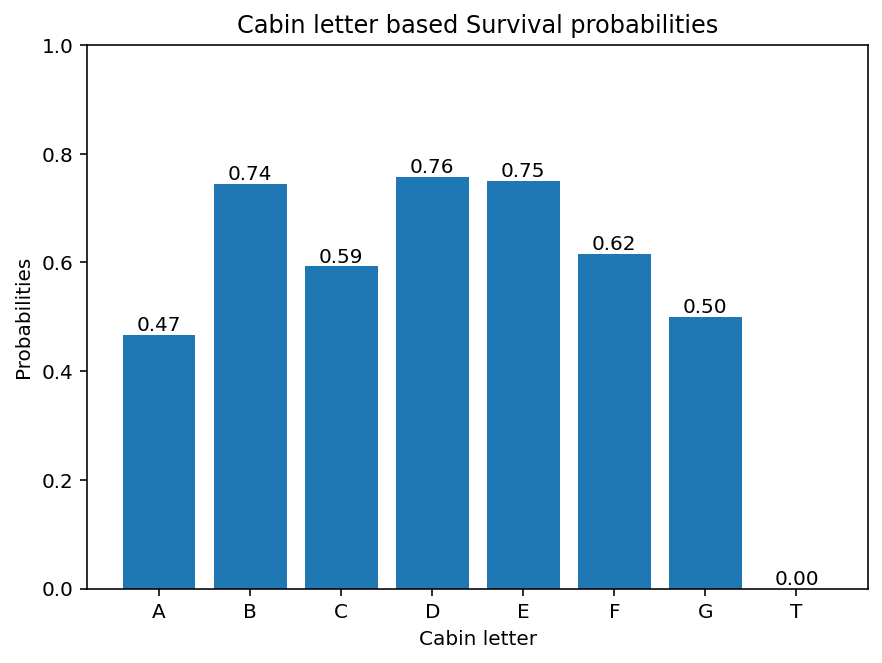

In [21]:
# Rearranging dataframe:
cabin_dict = defaultdict(list)
for number, index in enumerate(cabins.index):
    cabin_dict[cabins["Cabin"][index]] = cabin_letters[number]

cabins["Letters"] = cabins["Cabin"].replace(to_replace=cabin_dict)

fig, ax = plt.subplots(figsize=(7, 5))
x = np.unique(cabin_letters)
y = cabins.groupby("Letters").mean()["Survived"]

bar = ax.bar(x=x, height=y)
ax.set(title="Cabin letter based Survival probabilities",
       xlabel="Cabin letter",
       ylabel="Probabilities",
       ylim=[0, 1])

ax.bar_label(bar, fmt='%.2f');

In [22]:
repeated_letters = defaultdict(list)
    
for x in np.unique(cabins["Letters"]):
    repeated_letters[x] = len([letter for letter in cabins["Letters"] if letter == x])

repeated_letters

defaultdict(list,
            {'A': 15,
             'B': 47,
             'C': 59,
             'D': 33,
             'E': 32,
             'F': 13,
             'G': 4,
             'T': 1})

G and T letters have very few samples to predict something based on them.

B, D, and E have almost the same chances of survival - 75% mean with std = 0.667%.
A and G - 48.5% mean with std = 1.5%.
C and F - 60.5% mean with std = 1.5%.

Probably, we can group them together. We will decide after we see the complete analysis of cabin.

#### Numbers

Cabin feature also has a number after the letter - it has 1, 2 or 3 digits. Let's try to interpret them.

In [23]:
number_of_cabins = []
cabin_number = []
for cabin in cabins["Cabin"]:
    numbers = re.findall('[0-9]+', cabin)
    numbers = [int(number) for number in numbers]
    number_of_cabins.append(len(numbers))
    if len(numbers) == 1:
        cabin_number.append(numbers[0])
    elif len(numbers) > 1:
        mean = round(sum(numbers)/len(numbers))
        cabin_number.append(mean)
    else:
        cabin_number.append(0)

number_of_cabins = pd.Series(index=cabins.index, data=number_of_cabins, name="Number_of_cabins")
cabin_number = pd.Series(index=cabins.index, data=cabin_number, name="Cabin_number")

cabins = pd.concat([cabins, number_of_cabins, cabin_number], axis=1)

for i in cabins.index:
    cabins["Cabin_number"].loc[i] = cabin_number[i]
    cabins["Number_of_cabins"].loc[i] = number_of_cabins[i]

/Users/vagiz/Desktop/desktop_vagiz/Programming/env/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [24]:
cabins.head(8)

Survived  Pclass  \
PassengerId                     
2                   1       1   
4                   1       1   
7                   0       1   
11                  1       3   
12                  1       1   
22                  1       2   
24                  1       1   
28                  0       1   

                                                          Name     Sex   Age  \
PassengerId                                                                    
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
7                                      McCarthy, Mr. Timothy J    male  54.0   
11                             Sandstrom, Miss. Marguerite Rut  female   4.0   
12                                    Bonnell, Miss. Elizabeth  female  58.0   
22                                       Beesley, Mr. Lawrence    male  34.0   
24                                Sloper, Mr. William Thompson    male  28.0   
28                              Fortune, Mr. Charles Alexander    male  19.0   

             SibSp  Parch    Ticket      Fare        Cabin Embarked  \
PassengerId                                                           
2                1      0  PC 17599   71.2833          C85        C   
4                1      0    113803   53.1000         C123        S   
7                0      0     17463   51.8625          E46        S   
11               1      1   PP 9549   16.7000           G6        S   
12               0      0    113783   26.5500         C103        S   
22               0      0    248698   13.0000          D56        S   
24               0      0    113788   35.5000           A6        S   
28               3      2     19950  263.0000  C23 C25 C27        S   

             Prep_classes Letters  Number_of_cabins  Cabin_number  
PassengerId                                                        
2                       2       C                 1            85  
4                       2       C                 1           123  
7                       1       E                 1            46  
11                      3       G                 1             6  
12                      3       C                 1           103  
22                      1       D                 1            56  
24                      1       A                 1             6  
28                      1       C                 3            25

Let's visualize `Survived` and `Number_of_cabins`.

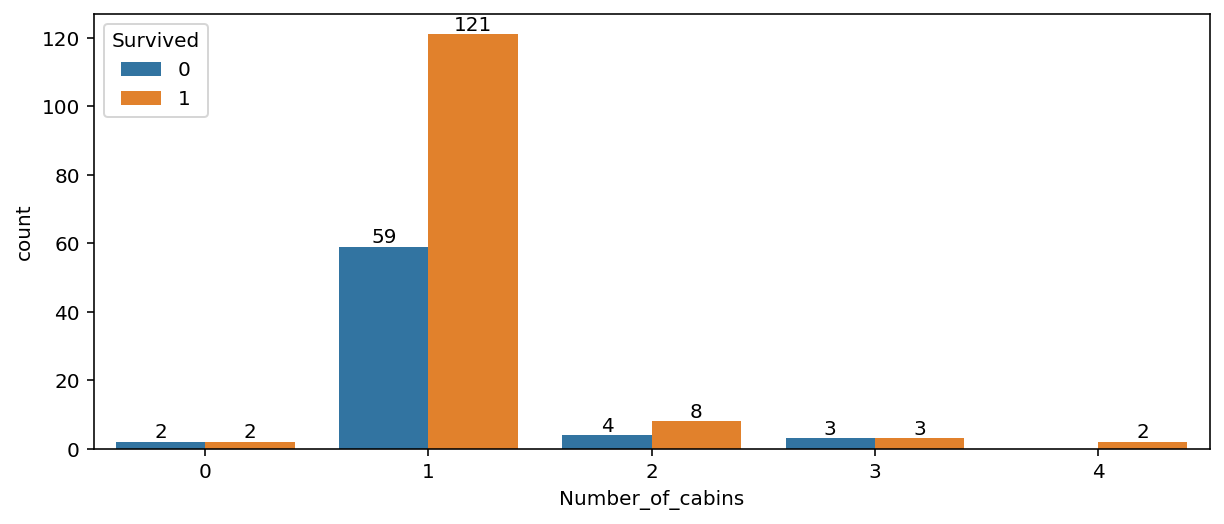

In [25]:
ax = sns.countplot(x="Number_of_cabins", hue="Survived", data=cabins)
plt.bar_label(ax.containers[0])
plt.bar_label(ax.containers[1]);

We can assign numbers to corresponding number of cabins.

Let's see if there is a correlation between `Survived` and `Cabin_number`.

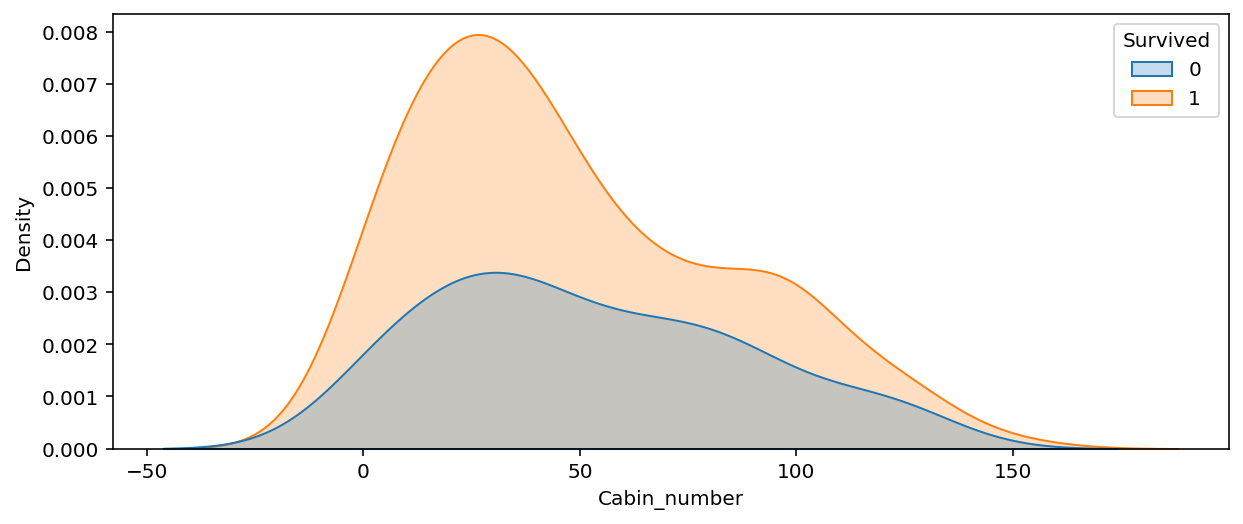

In [26]:
sns.kdeplot(x="Cabin_number", hue="Survived", data=cabins, shade=True);

`Cabin_number` has a Gaussian distribution with a right skew. We can leave this feature for model predictions.

### Fare

In [27]:
%%time
fare = main_data["Fare"].sort_values(ascending=True)
probabilities = np.array([])
for f in fare:
    p = len(main_data[(main_data["Survived"] == 1) & (main_data["Fare"] <= f)]) \
    /len(main_data[main_data["Fare"] <= f])
    probabilities = np.append(probabilities, p)

CPU times: user 315 ms, sys: 1.95 ms, total: 317 ms
Wall time: 316 ms


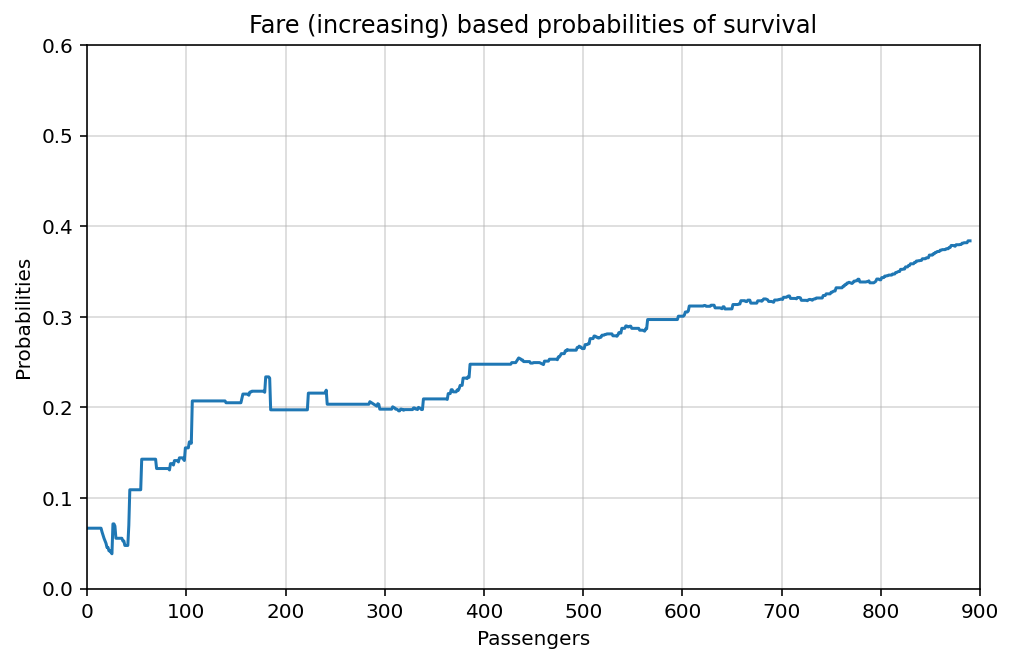

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(probabilities)
ax.set(title="Fare (increasing) based probabilities of survival",
       xlabel="Passengers",
       ylabel="Probabilities",
       ylim=(0,0.6),
       xlim=(0,900))
ax.grid(b=True, alpha=0.5)

The correlation is clear from that graph - initially, with very low fares, people had chances of survival about 0.05, and then this number steadily increases (as fare increases).

### Age & Sex

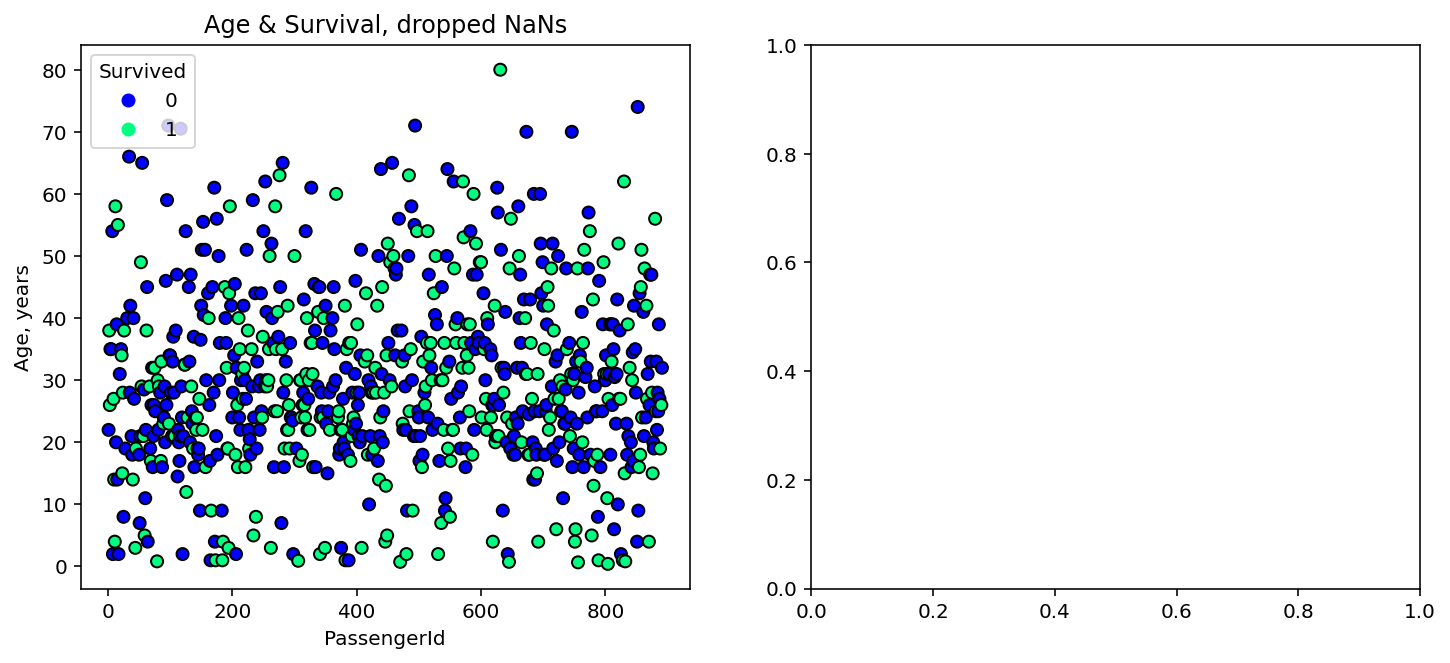

In [29]:
# Analyzing the ages of people (using scatterplot):

fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(12, 5))

# 1. Dropping NaNs:

y = main_data.dropna(subset=["Age"])["Age"]
x = main_data.dropna(subset=["Age"]).index
c = main_data.dropna(subset=["Age"])["Survived"]

scatter1 = ax1.scatter(x=x, y=y, c=c, cmap='winter', edgecolors='black')
ax1.legend(*scatter1.legend_elements(), title="Survived", loc='upper left')
ax1.set(title="Age & Survival, dropped NaNs",
        ylabel="Age, years",
        xlabel="PassengerId");

There is almost no pattern. Except, most children (age 0-10) survived the titanic. It means that they did it probably with parents (or mother at least). Let's try this hypothesis.

In [30]:
ch_10 = main_data[main_data["Age"] <= 10]
ch_10.describe()

Survived     Pclass        Age      SibSp      Parch        Fare  \
count  64.000000  64.000000  64.000000  64.000000  64.000000   64.000000   
mean    0.593750   2.640625   4.268281   1.843750   1.421875   30.434439   
std     0.495015   0.573687   2.976117   1.605731   0.528691   24.807302   
min     0.000000   1.000000   0.420000   0.000000   0.000000    8.516700   
25%     0.000000   2.000000   2.000000   0.750000   1.000000   19.131225   
50%     1.000000   3.000000   4.000000   1.000000   1.000000   27.000000   
75%     1.000000   3.000000   7.000000   3.250000   2.000000   31.387500   
max     1.000000   3.000000  10.000000   5.000000   2.000000  151.550000   

       Prep_classes  
count     64.000000  
mean       3.515625  
std        0.503706  
min        3.000000  
25%        3.000000  
50%        4.000000  
75%        4.000000  
max        4.000000

At average children under 10 had about 1.8 sibsp feature and 1.4 parch. It means that children were preferred for escape. Also, they took up far less space than average person.

Let's check the average `Survived` for different age groups:

In [31]:
probabilities = np.array([])
num_samples = np.array([])
years = np.array([i for i in range(0, 71, 10)])

for year in years:
    df = main_data[main_data["Age"] >= year]
    df = df[df["Age"] <= year + 10]
    prob = len(df[df["Survived"] == 1])/len(df)
    
    probabilities = np.append(probabilities, prob)
    num_samples = np.append(num_samples, len(df))
    
probabilities, num_samples, probabilities.mean(), len(main_data[main_data["Survived"] == 1])/len(main_data)

(array([0.59375   , 0.37606838, 0.35510204, 0.43888889, 0.39393939,
        0.42307692, 0.28571429, 0.14285714]),
 array([ 64., 117., 245., 180.,  99.,  52.,  21.,   7.]),
 0.37617463142016716,
 0.3838383838383838)

We got approximate distribution of probability of survival at certain age gap.

Let's graph results:

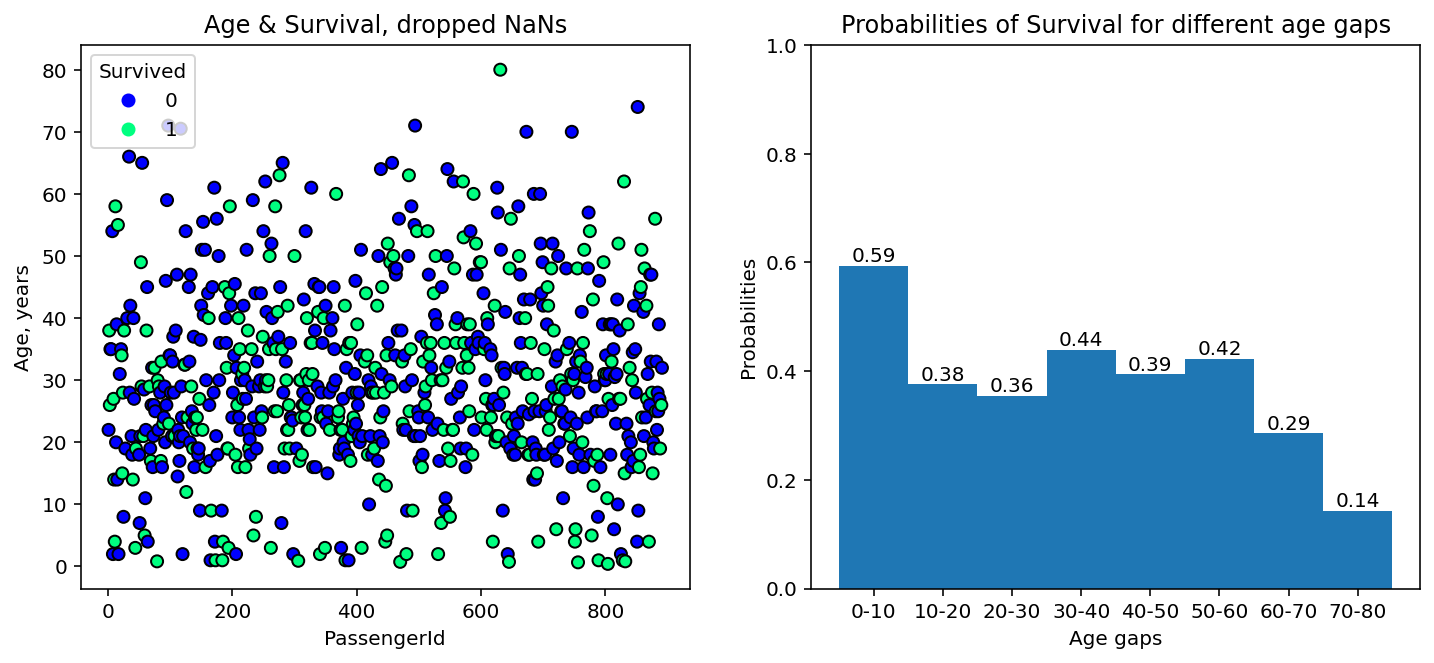

In [32]:
# Analyzing the ages of people (using scatterplot):

fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(12, 5))

# 1. Dropping NaNs:

y = main_data.dropna(subset=["Age"])["Age"]
x = main_data.dropna(subset=["Age"]).index
c = main_data.dropna(subset=["Age"])["Survived"]

scatter1 = ax1.scatter(x=x, y=y, c=c, cmap='winter', edgecolors='black')
ax1.legend(*scatter1.legend_elements(), title="Survived", loc='upper left')
ax1.set(title="Age & Survival, dropped NaNs",
        ylabel="Age, years",
        xlabel="PassengerId");

# 2. Using probabilities:

bar1 = ax2.bar(x=[f"{year}-{year+10}" for year in years], height=probabilities, width=1)
ax2.set_ylim((0,1))
ax2.set(title="Probabilities of Survival for different age gaps",
        xlabel="Age gaps",
        ylabel="Probabilities");

ax2.bar_label(bar1, fmt='%.2f');

The only correlation between the age feature and target variable is that there are clearly interesting moments on the graph above (right one). People from age 30-40 show second the best probability to survive, after small children 0-10. The reason for that is not obvious. Probably, these people are women with "Miss." title. This explains the trend and is a conclusion from graph about prepositions. In order to check that hypothesis, we can make the same probability distribution functions splitted based on sex.

In [33]:
main_data["Sex"].value_counts()  # two times differences but still appropriate to be based on

male      577
female    314
Name: Sex, dtype: int64

In [34]:
def get_probs_age(data):
    """
    Returns probabilities and age gaps based on "Age" feature of data DataFrame.
    """
    probabilities = []
    age_gaps = []
    upper = int(max(data["Age"]) - (max(data["Age"]) % 10) - 9)

    for year in range(0, upper, 10):
        df = data[(data["Age"] >= year) & (data["Age"] < year+10)]
        p = len(df[df["Survived"] == 1])/len(df)
        gap = f"{year}-{year+10}"
        probabilities.append(p)
        age_gaps.append(gap)
    
    return np.array(probabilities), np.array(age_gaps)

In [35]:
males = main_data[main_data["Sex"] == "male"]
females = main_data[main_data["Sex"] == "female"]

mp, mg = get_probs_age(males)
fp, fg = get_probs_age(females)

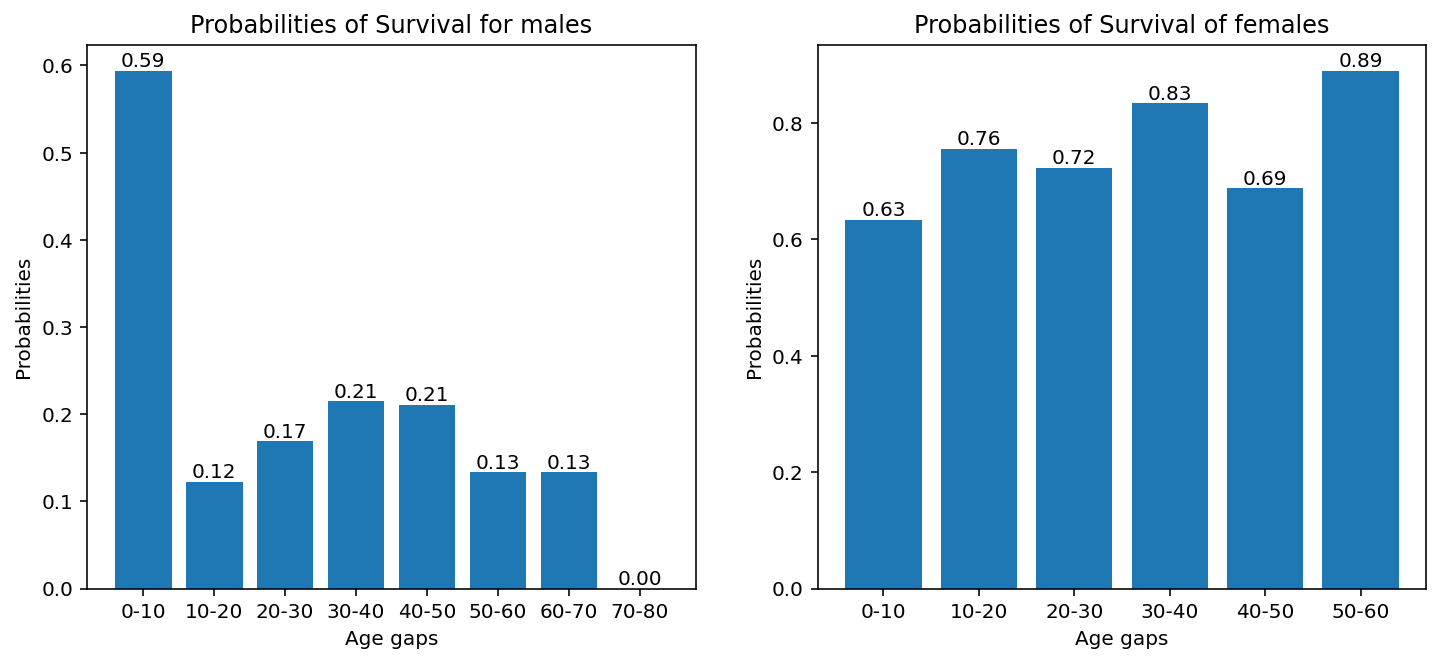

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows=1,
                               ncols=2,
                               figsize=(12,5))
ax1.bar(x=mg, height=mp)
ax1.set(title="Probabilities of Survival for males",
        xlabel="Age gaps",
        ylabel="Probabilities")

ax2.bar(x=fg, height=fp)
ax2.set(title="Probabilities of Survival of females",
        xlabel="Age gaps",
        ylabel="Probabilities")

ax1.bar_label(ax1.containers[0], fmt="%.2f")
ax2.bar_label(ax2.containers[0], fmt="%.2f");

Males have far less chances of survival except the 0-10 age gap. For 30-40 age gap, we can observe 83% of females to survive (Lady., Miss., Mrs., etc.), which is the reason of our observation. Clearly, age and sex have an influence on the target variable.

In order to predict `Age` NaN values, firstly, we can see if there are any strong relationships of `Age` with other variables.

#### Sex

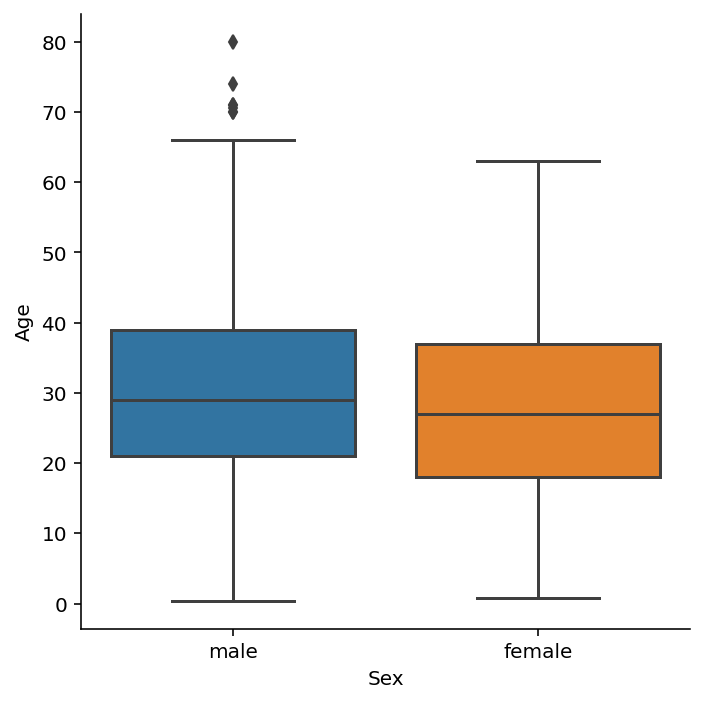

In [37]:
sns.catplot(y="Age", x="Sex", data=main_data, kind='box');

Almost the same distribution for `Age` of males and females.

#### Pclass

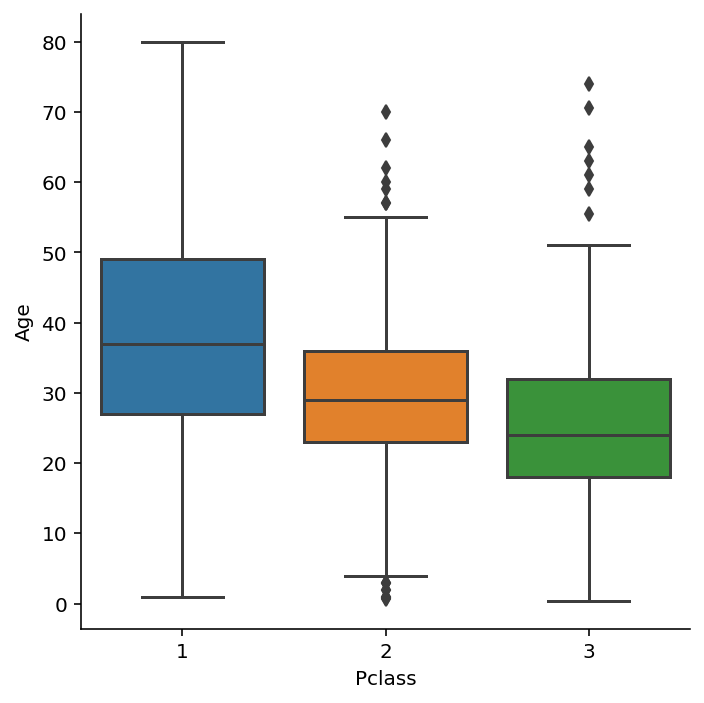

In [38]:
sns.catplot(y="Age", x="Pclass", data=main_data, kind="box");

The better class a person has, the higher is the age of that person on average.

#### SibSp

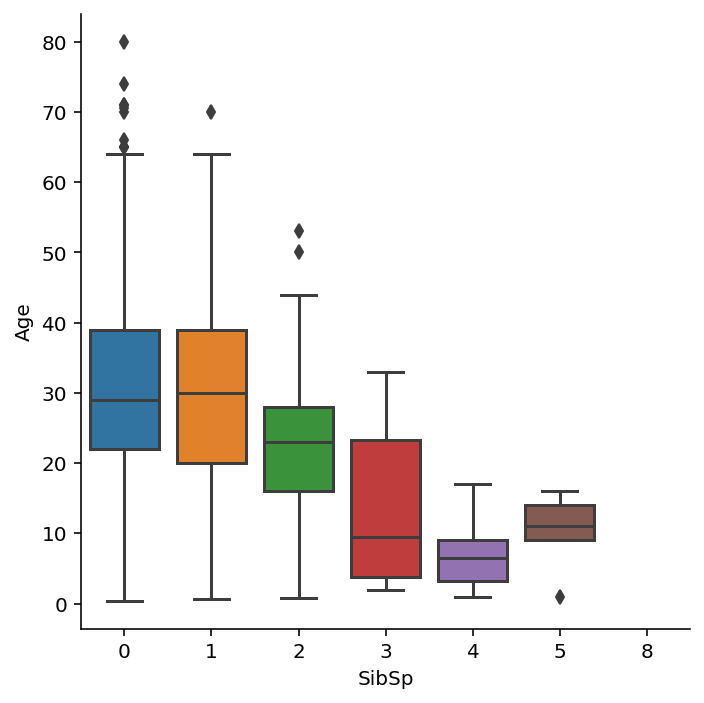

In [39]:
sns.catplot(data=main_data, y="Age", x="SibSp", kind="box");

The number of siblings/spouses can show a lot of information about person's average age.

#### Parch

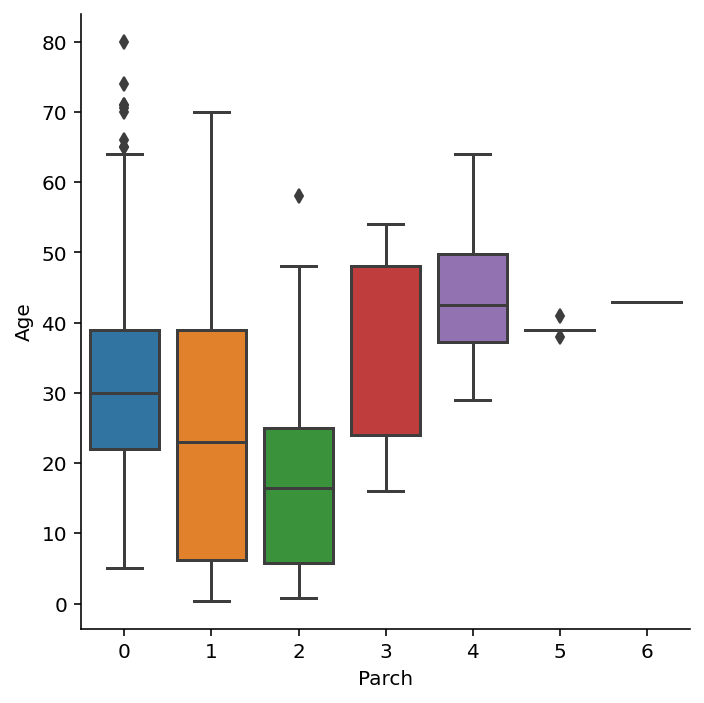

In [40]:
sns.catplot(data=main_data, y="Age", x="Parch", kind="box");

`Parch` value of 1 is the most common.

#### Fare

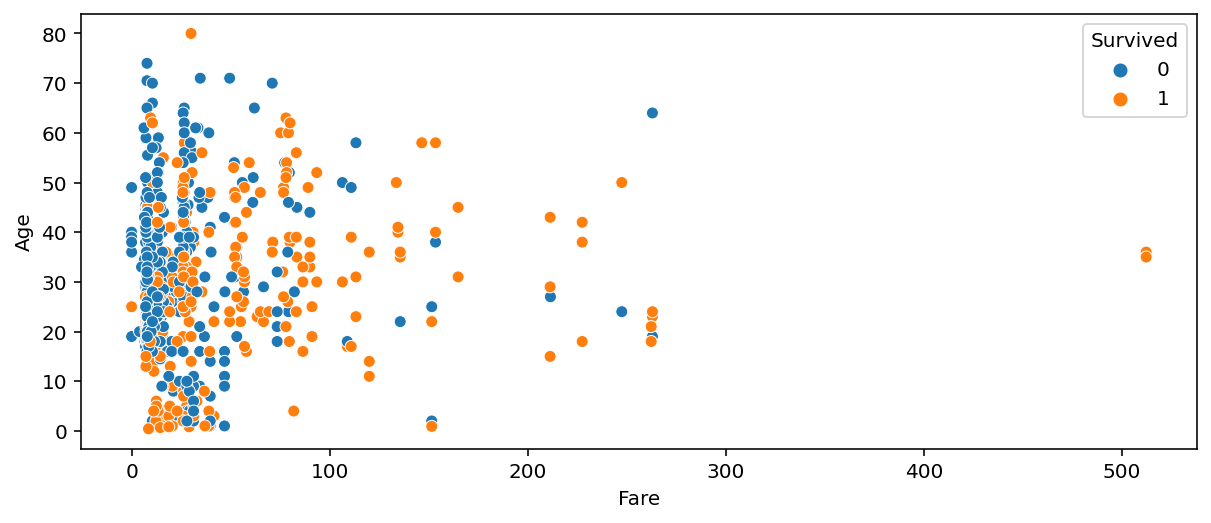

In [41]:
sns.scatterplot(data=main_data, y="Age", x="Fare", hue="Survived");

`Fare` has no correlation with `Age`. However, the greater the fare, the bigger the chances of survival. In order to analyze this trend better, we can visualize the probability function of `Survived` based on `Fare` *(see **Fare**)*. 

#### Prep_classes

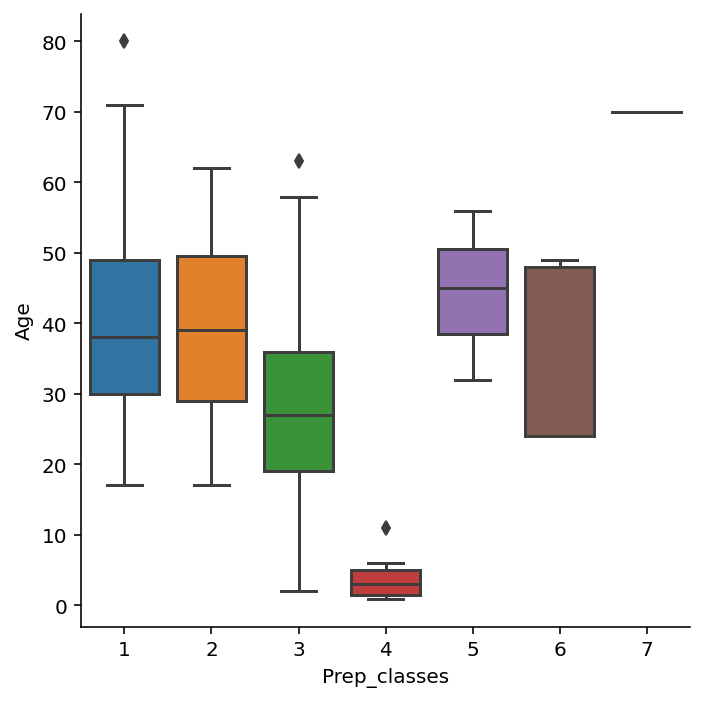

In [42]:
sns.catplot(data=cabins, y="Age", x="Prep_classes", kind='box');

In [43]:
main_data[main_data["Prep_classes"] == 4]["Age"].mean()

4.574166666666667

We can assign all people with title "Master." an age of 5.

#### Embarked

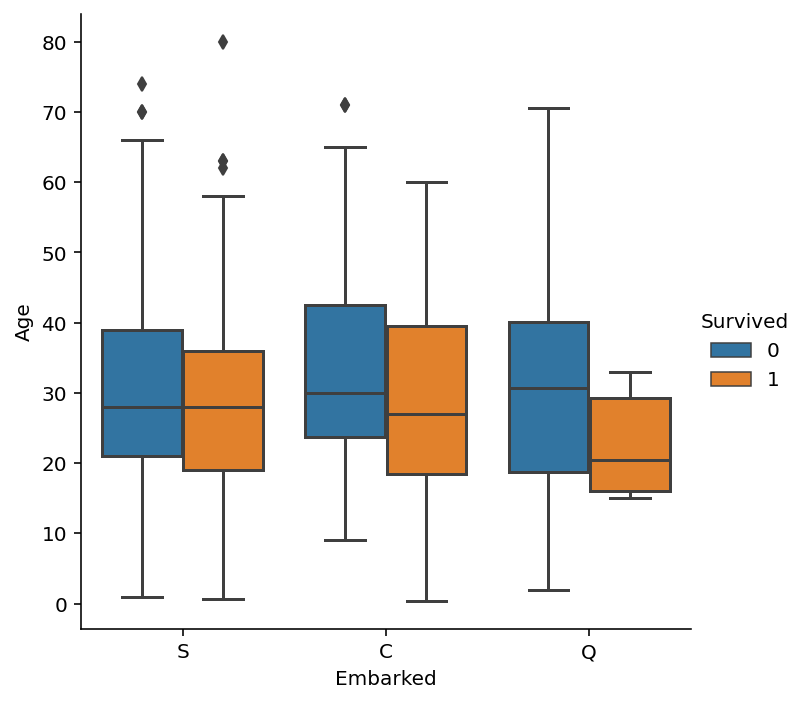

In [44]:
sns.catplot(data=main_data, x="Embarked", y="Age", hue="Survived", kind='box');

### Age NaN values

Having very low MSE will allow us to use predictions as input to other estimators. However, if models' performances won't be good enough, it is easier to drop `Age` NaN values. Any ways, we will see.

Now, we need to predict `Age` NaN values in order to use them in our subsequent modellings. The size of our subset with available `Age` values is 714 samples out of 891, which is good.

In [45]:
len(main_data["Age"]), main_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Name          891 non-null    object 
 3   Sex           891 non-null    object 
 4   Age           714 non-null    float64
 5   SibSp         891 non-null    int64  
 6   Parch         891 non-null    int64  
 7   Ticket        891 non-null    object 
 8   Fare          891 non-null    float64
 9   Cabin         204 non-null    object 
 10  Embarked      889 non-null    object 
 11  Prep_classes  891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


(891, None)

In [46]:
main_data

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
...               ...     ...   
887                 0       2   
888                 1       1   
889                 0       3   
890                 1       1   
891                 0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
...                                                        ...     ...   ...   
887                                      Montvila, Rev. Juozas    male  27.0   
888                               Graham, Miss. Margaret Edith  female  19.0   
889                   Johnston, Miss. Catherine Helen "Carrie"  female   NaN   
890                                      Behr, Mr. Karl Howell    male  26.0   
891                                        Dooley, Mr. Patrick    male  32.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  \
PassengerId                                                           
1                1      0         A/5 21171   7.2500   NaN        S   
2                1      0          PC 17599  71.2833   C85        C   
3                0      0  STON/O2. 3101282   7.9250   NaN        S   
4                1      0            113803  53.1000  C123        S   
5                0      0            373450   8.0500   NaN        S   
...            ...    ...               ...      ...   ...      ...   
887              0      0            211536  13.0000   NaN        S   
888              0      0            112053  30.0000   B42        S   
889              1      2        W./C. 6607  23.4500   NaN        S   
890              0      0            111369  30.0000  C148        C   
891              0      0            370376   7.7500   NaN        Q   

             Prep_classes  
PassengerId                
1                       1  
2                       2  
3                       3  
4                       2  
5                       1  
...                   ...  
887                     7  
888                     3  
889                     3  
890                     1  
891                     1  

[891 rows x 12 columns]

We need to:

1. Convert `Names` to `Prep_classes`, encode them, and drop `Name`.
2. Drop `Cabin`, `Sex`, `Fare`, and `Ticket` (`Ticket` is not analyzed yet).
3. Encode `Embarked`.
4. Split encoded df into train and test sets.

In [47]:
# define age preprocessing function 

def preprocess_age(df):
    """
    Returns df, X_train, X_test, y_train, y_test for predicting age.
    """
    np.random.seed(4)
    
    df = names_to_classes(df)  # adds new column with Prep_classes 
    for f in ["Cabin", "Name", "Sex", "Fare", "Ticket"]:  # drops uncorrelated features
        if f in df.columns:
            df = df.drop([f], axis=1)
            
    df = df.dropna()
    
    X = df.drop(["Age"], axis=1)
    y = df["Age"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    
    cat_features = ["Prep_classes", "Embarked", "Pclass"]  # features to encode using onehot
    
    transformer = ColumnTransformer(transformers=[
        ('onehot', OneHotEncoder(), cat_features)
    ])
    
    X_train = transformer.fit_transform(X_train)
    X_test = transformer.transform(X_test)
    
    return df, X_train, X_test, y_train, y_test

In [48]:
df, X_train, X_test, y_train, y_test = preprocess_age(main_data)
df

Survived  Pclass   Age  SibSp  Parch Embarked  Prep_classes
PassengerId                                                             
1                   0       3  22.0      1      0        S             1
2                   1       1  38.0      1      0        C             2
3                   1       3  26.0      0      0        S             3
4                   1       1  35.0      1      0        S             2
5                   0       3  35.0      0      0        S             1
...               ...     ...   ...    ...    ...      ...           ...
886                 0       3  39.0      0      5        Q             2
887                 0       2  27.0      0      0        S             7
888                 1       1  19.0      0      0        S             3
890                 1       1  26.0      0      0        C             1
891                 0       3  32.0      0      0        Q             1

[712 rows x 7 columns]

In [49]:
def check_model_performances(X_train, X_test, y_train, y_test, models):
    """
    Trains list of models and returns a list of performance characteristics.
    """
    np.random.seed(4)
    
    l = list()
    
    for i in range(len(models)):
        if models[i].__name__ == "KNeighborsRegressor":
            pipeline = Pipeline(steps=[
                ("scaler", StandardScaler(with_mean=False)),
                ("estimator", models[i]())
            ])
        else:   
            pipeline = Pipeline(steps=[
                ("estimator", models[i]())
            ])
        
        y_preds = pipeline.fit(X_train, y_train).predict(X_test)
        
        l.append({
            "name": models[i].__name__,
            "mse": mean_squared_error(y_test, y_preds),
            "y_preds": y_preds,
            "X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test
        })
        
    return l

In [50]:
models = [SVR, KNeighborsRegressor, RandomForestRegressor, LinearRegression]

l = check_model_performances(X_train, X_test, y_train, y_test, models)

for m in l:
    print(m["name"])
    print(m["mse"])
    print("-----")

SVR
138.538688680604
-----
KNeighborsRegressor
160.1122906013986
-----
RandomForestRegressor
124.46158204374083
-----
LinearRegression
125.15272177425067
-----


As we can see, predicting age leaded us to very inaccurate results. The reason here is that all the features that we used for predictions are **categorical**, and not numerical. The categorical data is not enough to predict these values.

In order to approach the problem in another way, we can try to classify age into gaps and predict using not regression models but **classification** ones.

In [51]:
def assign_age_classes(ages: pd.DataFrame, step=10):
    """
    Converts numerical age into categorical age with specified size of step (inclusive).
    """
    
    max_age = max(ages)
    classes = []
    
    if max_age % step == 0:
        number_of_gaps = max_age/step
    else:
        number_of_gaps = (max_age - (max_age % step))/step + 1
    
    for age in ages:
        c = (age - (age % step))/step + 1
        classes.append(int(c))
    
    if type(ages) == type(pd.Series):
        return pd.Series(data=classes, index=ages.index, name=ages.name)
    else:
        return classes

In [52]:
def preprocess_age_2(df):
    """
    Returns df, X_train, X_test, y_train, y_test for predicting age.
    """
    np.random.seed(4)
    
    df = names_to_classes(df)  # adds new column with Prep_classes 
    for f in ["Cabin", "Name", "Sex", "Fare", "Ticket"]:  # drops uncorrelated features
        if f in df.columns:
            df = df.drop([f], axis=1)
    
    df = df.dropna()
    
    X = df.drop(["Age"], axis=1)
    y = assign_age_classes(df["Age"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    
    cat_features = ["Prep_classes", "Embarked", "Pclass"]  # features to encode using onehot
    
    transformer = ColumnTransformer(transformers=[
        ('onehot', OneHotEncoder(), cat_features)
    ])
    
    X_train = transformer.fit_transform(X_train)
    X_test = transformer.transform(X_test)
    
    return df, X_train, X_test, y_train, y_test

In [53]:
df, X_train, X_test, y_train, y_test = preprocess_age_2(main_data)
df

Survived  Pclass   Age  SibSp  Parch Embarked  Prep_classes
PassengerId                                                             
1                   0       3  22.0      1      0        S             1
2                   1       1  38.0      1      0        C             2
3                   1       3  26.0      0      0        S             3
4                   1       1  35.0      1      0        S             2
5                   0       3  35.0      0      0        S             1
...               ...     ...   ...    ...    ...      ...           ...
886                 0       3  39.0      0      5        Q             2
887                 0       2  27.0      0      0        S             7
888                 1       1  19.0      0      0        S             3
890                 1       1  26.0      0      0        C             1
891                 0       3  32.0      0      0        Q             1

[712 rows x 7 columns]

In [54]:
def check_model_performances_2(X_train, X_test, y_train, y_test, models):
    """
    Trains list of models and returns a list of performance characteristics.
    """
    np.random.seed(4)
    
    l = list()
    
    for i in range(len(models)):
        if models[i].__name__ == "KNeighborsClassifier":
            pipeline = Pipeline(steps=[
                ("scaler", StandardScaler(with_mean=False)),
                ("estimator", models[i]())
            ])
        else:   
            pipeline = Pipeline(steps=[
                ("estimator", models[i]())
            ])
        
        y_preds = pipeline.fit(X_train, y_train).predict(X_test)
        
        l.append({
            "name": models[i].__name__,
            "accuracy": accuracy_score(y_test, y_preds),
            "y_preds": y_preds,
            "X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test
        })
        
    return l

In [55]:
models = [RandomForestClassifier, SVC, LogisticRegression, KNeighborsClassifier]

l = check_model_performances_2(X_train, X_test, y_train, y_test, models)

for m in l:
    print(m["name"])
    print(m["accuracy"])
    print("-----")

RandomForestClassifier
0.3076923076923077
-----
SVC
0.32867132867132864
-----
LogisticRegression
0.38461538461538464
-----
KNeighborsClassifier
0.1888111888111888
-----


The same picture with classifiers - the accuracy of multiclass predictions is very low.

We need to see if `Age` is very useful for predicting `Survived`.

### Baseline modelling, `Survived`.

We will first model without age and then - with it.

In [56]:
main_data

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
...               ...     ...   
887                 0       2   
888                 1       1   
889                 0       3   
890                 1       1   
891                 0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
...                                                        ...     ...   ...   
887                                      Montvila, Rev. Juozas    male  27.0   
888                               Graham, Miss. Margaret Edith  female  19.0   
889                   Johnston, Miss. Catherine Helen "Carrie"  female   NaN   
890                                      Behr, Mr. Karl Howell    male  26.0   
891                                        Dooley, Mr. Patrick    male  32.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  \
PassengerId                                                           
1                1      0         A/5 21171   7.2500   NaN        S   
2                1      0          PC 17599  71.2833   C85        C   
3                0      0  STON/O2. 3101282   7.9250   NaN        S   
4                1      0            113803  53.1000  C123        S   
5                0      0            373450   8.0500   NaN        S   
...            ...    ...               ...      ...   ...      ...   
887              0      0            211536  13.0000   NaN        S   
888              0      0            112053  30.0000   B42        S   
889              1      2        W./C. 6607  23.4500   NaN        S   
890              0      0            111369  30.0000  C148        C   
891              0      0            370376   7.7500   NaN        Q   

             Prep_classes  
PassengerId                
1                       1  
2                       2  
3                       3  
4                       2  
5                       1  
...                   ...  
887                     7  
888                     3  
889                     3  
890                     1  
891                     1  

[891 rows x 12 columns]

In [57]:
def preprocess_baseline(df):
    df = df.drop(["Age", "Cabin", "Name", "Ticket"], axis=1)
    
    df = df.dropna()
    
    cat_features = ["Sex", "Embarked"]
    transformer = ColumnTransformer(transformers=[
        ('onehot', OneHotEncoder(), cat_features)
    ])
    
    X = df.drop(["Survived"], axis=1)
    y = df["Survived"]
    
    X = transformer.fit_transform(X)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return df, X_train, X_test, y_train, y_test

In [58]:
df, X_train, X_test, y_train, y_test = preprocess_baseline(main_data)
df

Survived  Pclass     Sex  SibSp  Parch     Fare Embarked  \
PassengerId                                                             
1                   0       3    male      1      0   7.2500        S   
2                   1       1  female      1      0  71.2833        C   
3                   1       3  female      0      0   7.9250        S   
4                   1       1  female      1      0  53.1000        S   
5                   0       3    male      0      0   8.0500        S   
...               ...     ...     ...    ...    ...      ...      ...   
887                 0       2    male      0      0  13.0000        S   
888                 1       1  female      0      0  30.0000        S   
889                 0       3  female      1      2  23.4500        S   
890                 1       1    male      0      0  30.0000        C   
891                 0       3    male      0      0   7.7500        Q   

             Prep_classes  
PassengerId                
1                       1  
2                       2  
3                       3  
4                       2  
5                       1  
...                   ...  
887                     7  
888                     3  
889                     3  
890                     1  
891                     1  

[889 rows x 8 columns]

In [59]:
def check_binary_performances(X_train, X_test, y_train, y_test, models):
    """
    Trains list of binary classification models and returns a list of performance characteristics.
    """
    np.random.seed(4)
    
    l = list()
    
    for i in range(len(models)):
        if models[i].__name__ == "KNeighborsClassifier":
            pipeline = Pipeline(steps=[
                ("scaler", StandardScaler(with_mean=False)),
                ("estimator", models[i]())
            ])
        else:   
            pipeline = Pipeline(steps=[
                ("estimator", models[i]())
            ])
        
        y_preds = pipeline.fit(X_train, y_train).predict(X_test)
        
        l.append({
            "name": models[i].__name__,
            "report": classification_report(y_test, y_preds),
            "accuracy": accuracy_score(y_test, y_preds),
            "y_preds": y_preds,
            "X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test
        })
        
    return l

In [60]:
models = [RandomForestClassifier, SVC, KNeighborsClassifier, LogisticRegression]

l = check_binary_performances(X_train, X_test, y_train, y_test, models)

for m in l:
    print(m["name"])
    print(m["accuracy"])
    print(m["report"])
    print("-----")

RandomForestClassifier
0.797752808988764
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       108
           1       0.79      0.66      0.72        70

    accuracy                           0.80       178
   macro avg       0.80      0.77      0.78       178
weighted avg       0.80      0.80      0.79       178

-----
SVC
0.797752808988764
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       108
           1       0.79      0.66      0.72        70

    accuracy                           0.80       178
   macro avg       0.80      0.77      0.78       178
weighted avg       0.80      0.80      0.79       178

-----
KNeighborsClassifier
0.6235955056179775
              precision    recall  f1-score   support

           0       0.65      0.82      0.73       108
           1       0.54      0.31      0.40        70

    accuracy                           0.62       178
   macro avg 

The results show that 3 out of 4 different classifiers made the same predictions and same combined accuracy of 79.5%. They had the same tpr and fpr. 

Now, we will use `Age` for modelling.

In [61]:
def preprocess_baseline(df):
    df = df.drop(["Cabin", "Name", "Ticket"], axis=1)
    
    df = df.dropna()
    
    cat_features = ["Sex", "Embarked"]
    transformer = ColumnTransformer(transformers=[
        ('onehot', OneHotEncoder(), cat_features)
    ])
    
    X = df.drop(["Survived"], axis=1)
    y = df["Survived"]
    
    X = transformer.fit_transform(X)
    
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return df, X_train, X_test, y_train, y_test

In [62]:
df, X_train, X_test, y_train, y_test = preprocess_baseline(main_data)
df

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  \
PassengerId                                                                   
1                   0       3    male  22.0      1      0   7.2500        S   
2                   1       1  female  38.0      1      0  71.2833        C   
3                   1       3  female  26.0      0      0   7.9250        S   
4                   1       1  female  35.0      1      0  53.1000        S   
5                   0       3    male  35.0      0      0   8.0500        S   
...               ...     ...     ...   ...    ...    ...      ...      ...   
886                 0       3  female  39.0      0      5  29.1250        Q   
887                 0       2    male  27.0      0      0  13.0000        S   
888                 1       1  female  19.0      0      0  30.0000        S   
890                 1       1    male  26.0      0      0  30.0000        C   
891                 0       3    male  32.0      0      0   7.7500        Q   

             Prep_classes  
PassengerId                
1                       1  
2                       2  
3                       3  
4                       2  
5                       1  
...                   ...  
886                     2  
887                     7  
888                     3  
890                     1  
891                     1  

[712 rows x 9 columns]

In [63]:
models = [RandomForestClassifier, SVC, KNeighborsClassifier, LogisticRegression]

l = check_binary_performances(X_train, X_test, y_train, y_test, models)

for m in l:
    print(m["name"])
    print(m["accuracy"])
    print(m["report"])
    print("-----")

RandomForestClassifier
0.7412587412587412
              precision    recall  f1-score   support

           0       0.77      0.82      0.80        88
           1       0.68      0.62      0.65        55

    accuracy                           0.74       143
   macro avg       0.73      0.72      0.72       143
weighted avg       0.74      0.74      0.74       143

-----
SVC
0.7412587412587412
              precision    recall  f1-score   support

           0       0.77      0.82      0.80        88
           1       0.68      0.62      0.65        55

    accuracy                           0.74       143
   macro avg       0.73      0.72      0.72       143
weighted avg       0.74      0.74      0.74       143

-----
KNeighborsClassifier
0.7412587412587412
              precision    recall  f1-score   support

           0       0.77      0.82      0.80        88
           1       0.68      0.62      0.65        55

    accuracy                           0.74       143
   macro av

With `Age` variable, all models have the exact same result of 74.126% accuracy. Probably, there is very clear relationship, but we need more features to increase the predictive power of models.

In order to do so, `Cabin`, `Ticket`, and `Age` must be somehow included into process. 